# 주제 : 학종이만한 사진을 사진만한 크기로 확대하기
--------------
## 실습 가이드
    1. 데이터를 다운로드하여 Colab에 불러옵니다.
    2. 필요한 라이브러리는 모두 코드로 작성되어 있습니다.
    3. 코드는 위에서부터 아래로 순서대로 실행합니다.
    4. 전체 문제 구성은 좌측 첫 번째 아이콘을 통해 확인할 수 있습니다.

## 데이터 소개
  - 이번 주제의 데이터는 portrait 데이터로 유명한 PFCN dataset을 이용합니다.
  ![PFCN dataset](https://www.researchgate.net/profile/Dawei_Li49/publication/334417334/figure/fig4/AS:832930272276492@1575597460956/Sample-images-from-the-PFCN-dataset.jpg)

  위의 이미지는 다음과 같은 것을 보여줍니다.  
- 800x600의 사람 portrait 이미지  
     - ?????.png  
- 사람 영역에 대한 흑백 portrait 이미지
     - ?????_matte.png
- pfcn_original
     - 원본 800x600 이미지들
- pfcn_small
     - colab용 100x75 이미지들



   - 데이터 출처:
     - [PFCN dataset](https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo)
     - [pfcn_small](https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing)

## 최종 목표

  - 작게 줄인 PFCN 데이터를 이용하여 사람 영역 추출
  - 코렙에 구글 drive 연동
  - 큰 사진을 작게 줄이기
  - 이미지에 대한 오토인코더식 접근 방법

  - 출제자 : 손근영 강사


In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34


## Step 1. 도입전 기본 처리

### 1. 구글 drive와 colab 연동하고 PFCN 데이터 살펴보기

In [2]:
# 구글 drive와 colab 연동하기
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
# 데이터를 np array로 training에서 사람 이미지 한장과 영역 이미지 한장을 불러오는 코드를 작성해주세요. (x, y로 변수 대입)
import imageio
import glob
data_path = "/content/drive/MyDrive/[강의자료] 퀴즈처럼 풀면서 배우는 파이썬 딥러닝 300제+ 연습문제 패키치 Online/PART 1~3 강의자료/dataset"

x =imageio.imread(data_path + "/training/00001.png")

### 문제 2. x의 shape을 출력해보세요.

In [7]:
# 데이터의 크기를 shape 함수를 통해 출력해주세요.
x.shape

(100, 75, 3)

### 문제 3. x를 plt를 통하여 출력하세요.

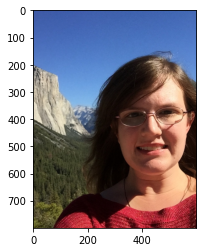

In [5]:
# x를 plt를 이용하여 출력하는 코드를 작성해보세요
plt.imshow(x)

### 문제 4. (800, 600)의 의미지는 colab에서 돌리기에 너무 큽니다. (100, 75)로 이미지를 줄여보세요

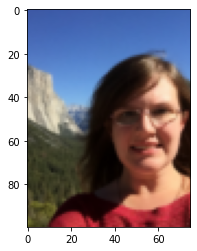

In [10]:
# x를 각각 (800, 600, 3) -> (100, 75, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.
from skimage.transform import resize
y = resize(x, (100, 75))
plt.imshow(y)

### 문제 5. (50, 37)로 이미지를 줄여보고 출력해보세요

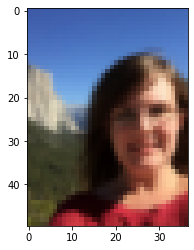

In [11]:
# x를 각각 (800, 600, 3) -> (50, 37, 3)로 줄이고 plt에서 확인하는 코드를 작성하세요.
z = resize(x, (50, 37))
plt.imshow(z)

### 문제 6. pfcn_small.npz 데이터에서 학습, 테스트 데이터를 로드하세요.

In [ ]:
# pfcn_small.npz에서 train_images, test_images를 train_big_images, test_big_images의 이름으로 np array로 로드하세요.
#https://drive.google.com/file/d/1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl/view?usp=sharing

!gdown --id 1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl

In [13]:
pfcn_small = np.load('/content/drive/MyDrive/[강의자료] 퀴즈처럼 풀면서 배우는 파이썬 딥러닝 300제+ 연습문제 패키치 Online/PART 1~3 강의자료/dataset/pfcn_small.npz')
train_big_images = pfcn_small["train_images"]
test_big_images = pfcn_small["test_images"]

### 문제 7. train_big_images, test_big_images를 (50, 37, 3)으로 줄인 이미지를 할당하세요.

In [15]:
# train_big_images, test_big_images를 (50, 37, 3)으로 축소하고 train_small_images / test_small_images의 이름으로 할당하세요.
train_small_images = np.array([resize(img, (50, 37)) for img in train_big_images])
test_small_images = np.array([resize(img, (50, 37)) for img in test_big_images])
train_small_images.shape
test_small_images.shape

(300, 50, 37, 3)

### 문제 8. train_big_images에서 0이 아닌 값들을 출력해보세요.

In [17]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요.
print(train_big_images[0][train_big_images[0] != 0][:10])

[0.23627451 0.34803922 0.64705882 0.24509804 0.35686275 0.65588235
 0.25490196 0.36470588 0.66470588 0.2372549 ]


### 문제 9. train_big_images의 dtype을 출력해보세요.

In [18]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
train_big_images.dtype

dtype('float64')

## Step 2. 전처리

### 문제 10. train/test_big_images 이미지 데이터의 범위 확인

In [19]:
# train/test_big_images의 shape과 dtype, 0이 아닌 숫자를 출력하는 코드를 작성하세요.
print(train_big_images.shape)
print(train_big_images.dtype)
print(train_big_images[0][train_big_images[0] != 0][:5])
print(test_big_images.shape)
print(test_big_images.dtype)
print(test_big_images[0][test_big_images[0] != 0][:5])

(1700, 100, 75, 3)
float64
[0.23627451 0.34803922 0.64705882 0.24509804 0.35686275]
(300, 100, 75, 3)
float64
[0.50980392 0.64117647 0.64313725 0.51568627 0.64705882]


### 문제 11. images 이미지 데이터의 최소/최대값을 출력

In [20]:
# train/test 전체 데이터에서 각 images의 min, max를 출력하는 코드를 작성하세요.
print(min(train_big_images.reshape(-1)), max(train_big_images.reshape(-1)))
print(min(test_big_images.reshape(-1)), max(test_big_images.reshape(-1)))

0.0 1.0
0.0 1.0


## Step 3. 시각화 방법

### 문제 12. train_big_image의 이미지를 5장 획득하여 (5, 100, 75, 3)의 shape을 출력하세요.

In [21]:
# (배치, 100, 75, 3)인 train_big_images에서 (5, 100, 75, 3)을 획득하는 코드를 작성하세요.
train_big_images[:5].shape

(5, 100, 75, 3)

### 문제 13. transpose 함수를 이용하여 (100, 75 * 5, 3)로 shape을 변경해보세요.

In [22]:
# transpose는 tensor의 axis를 섞는 기능을 합니다.
# 해당 기능을 이용해서 (100, 375, 3)을 작성하는 코드를 작성해보세요.
train_big_images[:5].transpose(1, 0, 2, 3).reshape(100, -1, 3).shape

(100, 375, 3)

### 문제 14. (100, 375, 3)이 된 tensor를 plt로 출력해보세요.

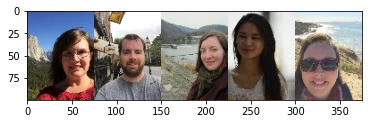

In [23]:
# (100, 375, 3)의 이미지를 plt로 출력해보세요.
plt.imshow(train_big_images[:5].transpose(1, 0, 2, 3).reshape(100, -1, 3))
plt.show()

### 문제 15. small도 (50, 37 * 5, 3)으로 plt로 출력해보세요.

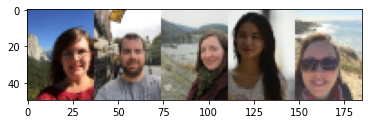

In [24]:
# (50, 37 * 5, 3)의 이미지를 plt로 출력해보세요.
plt.imshow(train_small_images[:5].transpose(1, 0, 2, 3).reshape(50, -1, 3))
plt.show()

## Step 4. 모델링

### 문제 16. small 학습셋을 big으로 고해상도 변경하는 모델을 작성하세요.

In [29]:
# input (50, 37, 3), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, Activation, Dropout, concatenate, BatchNormalization
from keras.models import Model

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_resolution():
    inputs = Input((50, 37, 3))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D((2,2))(c1)
    d1 = Dropout(0.3)(p1)

    c2 = conv2d_block(d1, 32)
    p2 = MaxPool2D((2,2))(c2)
    d2 = Dropout(0.3)(p2)

    c3 = conv2d_block(d2, 64)
    p3 = MaxPool2D((2,2))(c3)
    d3 = Dropout(0.3)(p3)

    c4 = conv2d_block(d3, 128)
    p4 = MaxPool2D((2,2))(c4)
    d4 = Dropout(0.3)(p4)

    latent = conv2d_block(d4 , 256)

    u1 = Conv2DTranspose(128, 2, 2)(latent)
    u1 = concatenate((u1, c4))
    u1 = Dropout(0.3)(u1)
    c5 = conv2d_block(u1, 128)

    u2 = Conv2DTranspose(64, 2, 2, output_padding=(0, 1))(c5)
    u2 = concatenate((u2, c3))
    u2 = Dropout(0.3)(u2)
    c6 = conv2d_block(u2, 64)

    u3 = Conv2DTranspose(32, 2, 2, output_padding=(1, 0))(c6)
    u3 = concatenate((u3, c2))
    u3 = Dropout(0.3)(u3)
    c7 = conv2d_block(u3, 32)

    u4 = Conv2DTranspose(16, 2, 2, output_padding=(0, 1))(c7)
    u4 = concatenate((u4, c1))
    u4 = Dropout(0.3)(u4)
    outputs = conv2d_block(u4, 16)

    outputs = Conv2DTranspose(16, 2, 2, output_padding=(0, 1))(outputs)
    outputs = Conv2D(3, 1, activation="sigmoid")(outputs)

    return Model(inputs, outputs)

unet_resolution().summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50, 37, 3)]  0           []                               
                                                                                                  
 conv2d_55 (Conv2D)             (None, 50, 37, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_54 (BatchN  (None, 50, 37, 16)  64          ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 50, 37, 16)   0           ['batch_normalization_54[0]

### 문제 17. 모델을 할당 받고 서머리를 출력해보세요.

In [31]:
# unet_resolution() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_resolution()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50, 37, 3)]  0           []                               
                                                                                                  
 conv2d_74 (Conv2D)             (None, 50, 37, 16)   448         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_72 (BatchN  (None, 50, 37, 16)  64          ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_72 (Activation)     (None, 50, 37, 16)   0           ['batch_normalization_72[0]

### 문제 18. 만든 모델에 로스와 옵티마이저, 메트릭을 설정하세요.

In [32]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

### 문제 19. 만든 모델에 train_small_images를 학습시켜 보세요.

In [33]:
# train_small_images 학습시키고 5 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
hist = model.fit(train_small_images, train_big_images, validation_data=(test_small_images, test_big_images), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 19s 106ms/step - loss: 0.1469 - accuracy: 0.5609 - val_loss: 0.1941 - val_accuracy: 0.6777
Epoch 2/25
54/54 [==============================] - 4s 71ms/step - loss: 0.0777 - accuracy: 0.6792 - val_loss: 0.1686 - val_accuracy: 0.7174
Epoch 3/25
54/54 [==============================] - 4s 67ms/step - loss: 0.0694 - accuracy: 0.7294 - val_loss: 0.1374 - val_accuracy: 0.7517
Epoch 4/25
54/54 [==============================] - 4s 68ms/step - loss: 0.0660 - accuracy: 0.7575 - val_loss: 0.1152 - val_accuracy: 0.7726
Epoch 5/25
54/54 [==============================] - 3s 62ms/step - loss: 0.0640 - accuracy: 0.7678 - val_loss: 0.0985 - val_accuracy: 0.7814
Epoch 6/25
54/54 [==============================] - 3s 63ms/step - loss: 0.0627 - accuracy: 0.7722 - val_loss: 0.0812 - val_accuracy: 0.7884
Epoch 7/25
54/54 [==============================] - 3s 62ms/step - loss: 0.0612 - accuracy: 0.7752 - val_loss: 0.0657 - val_accuracy: 0.7916
Epoch 8/25


### 문제 20. 학습 진행 사항을 plt으로 출력하세요.

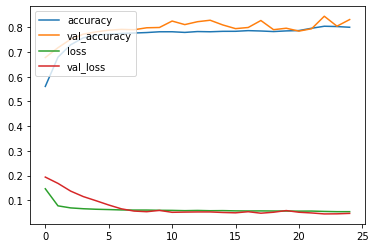

In [34]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

## Step 5. 결과 확인

### 문제 21. 완성된 모델에서 test_image를 1장 넣고 결과를 res 변수에 저정하세요.

In [35]:
# 모델에 test_small_images 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(test_small_images[1:2])
res.shape, test_small_images[:1].shape

((1, 100, 75, 3), (1, 50, 37, 3))

### 문제 22. test_small_images[1]을 resize 함수를 이용하여 (100, 75)으로 2배 확대시키세요.

In [36]:
# test_small_images[1]을 resize 함수를 이용해여 (100, 75, 3) 으로 2배 확대하는 코드를 작성하세요.
exp = resize(test_small_images[1], (100, 75))
exp.shape

(100, 75, 3)

### 문제 23. res와 확대한 이미지, test_big_images[1]을 동시에 출력시켜 보세요.

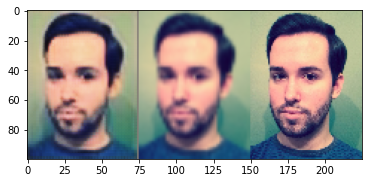

In [37]:
# res와 확대한 이미지, test_big_images[1]]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
imgs = np.concatenate([res[0], exp, test_big_images[1]], axis = 1)
plt.imshow(imgs)

### 문제 24. 3장의 test_small_images를 모델에 넣은 뒤 결과를 문제 23 방식으로 비교하세요.

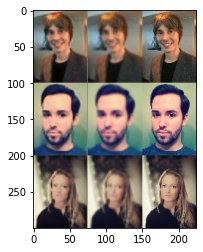

In [38]:
# 3장의 이미지를 모델에 넣고 결과를 23번 같은 방식으로 비교하는 코드를 작성하세요
res = model.predict(test_small_images[:3])
exps = np.array([resize(img, (100,75)) for img in test_small_images[:3]])
imgs = np.concatenate([res, exps, test_big_images[:3]], axis=2).reshape((300, -1 , 3))
plt.imshow(imgs)

### 기타

그러면 주어진 shape보다 큰 사진에 sr을 하려면 어떻게 할까?

In [40]:
test_lr_images = np.array([resize(img, (100,75)) for img in test_small_images])
train_lr_images = np.array([resize(img, (100,75)) for img in train_small_images])

In [41]:
test_small_images.shape, test_lr_images.shape

((300, 50, 37, 3), (300, 100, 75, 3))

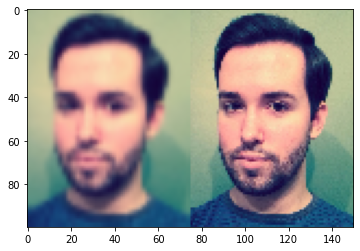

In [42]:
imgs = np.concatenate([test_lr_images[1], test_big_images[1]], axis = 1)
plt.imshow(imgs)

In [43]:
from keras.layers import Average

def srcnn():
    inputs = Input((100, 75, 3))
    x = Conv2D(64, 9, activation = 'relu', padding="same")(inputs)

    x1 = Conv2D(32, 1, activation = 'relu', padding="same")(x)
    x2 = Conv2D(32, 3, activation = 'relu', padding="same")(x)
    x3 = Conv2D(32, 5, activation = 'relu', padding="same")(x)
    x = Average()([x1, x2, x3])

    outputs = Conv2D(3, 5, activation="relu", padding="same")(x)
    model = Model(inputs, outputs)
    model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
    return model

model2 = srcnn()
model2.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 100, 75, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_93 (Conv2D)             (None, 100, 75, 64)  15616       ['input_7[0][0]']                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 100, 75, 32)  2080        ['conv2d_93[0][0]']              
                                                                                                  
 conv2d_95 (Conv2D)             (None, 100, 75, 32)  18464       ['conv2d_93[0][0]']        

In [44]:
hist2 = model2.fit(train_lr_images, train_big_images, validation_data=(test_lr_images, test_big_images), epochs=25, verbose=1)

Epoch 1/25
54/54 [==============================] - 10s 125ms/step - loss: 0.1188 - accuracy: 0.6451 - val_loss: 0.0742 - val_accuracy: 0.7978
Epoch 2/25
54/54 [==============================] - 6s 107ms/step - loss: 0.0674 - accuracy: 0.7664 - val_loss: 0.0670 - val_accuracy: 0.8287
Epoch 3/25
54/54 [==============================] - 6s 107ms/step - loss: 0.0621 - accuracy: 0.7766 - val_loss: 0.0521 - val_accuracy: 0.8069
Epoch 4/25
54/54 [==============================] - 6s 107ms/step - loss: 0.0545 - accuracy: 0.7942 - val_loss: 0.0488 - val_accuracy: 0.7930
Epoch 5/25
54/54 [==============================] - 6s 107ms/step - loss: 0.0512 - accuracy: 0.8114 - val_loss: 0.0452 - val_accuracy: 0.8243
Epoch 6/25
54/54 [==============================] - 6s 107ms/step - loss: 0.0460 - accuracy: 0.8350 - val_loss: 0.0520 - val_accuracy: 0.8298
Epoch 7/25
54/54 [==============================] - 6s 108ms/step - loss: 0.0460 - accuracy: 0.8230 - val_loss: 0.0435 - val_accuracy: 0.8676
Epoch

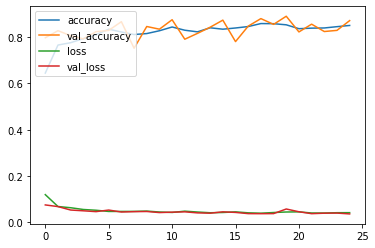

In [45]:
plt.plot(hist2.history['accuracy'], label='accuracy')
plt.plot(hist2.history['val_accuracy'], label='val_accuracy')
plt.plot(hist2.history['loss'], label='loss')
plt.plot(hist2.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


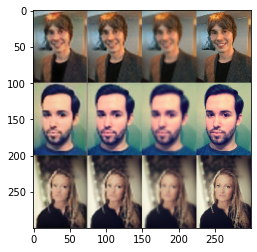

In [46]:
res1 = model.predict(test_small_images[:3])
res2 = model2.predict(test_lr_images[:3])
imgs = np.concatenate([res1, res2, test_lr_images[:3], test_big_images[:3]], axis=2).reshape((300, -1 , 3))
plt.imshow(imgs)

## Step 6. 모델 저장 및 로드, 다운

### 문제 25. 모델을 저장하세요.

In [ ]:
# 모델을 저장하는 코드를 작성하세요.
model.save('./lecture007.h5')
model2.save('./lecture007-1.h5')

### 문제 26. 모델 파일을 새로운 모델에 로드하세요.

In [ ]:
# 모델을 로드하는 코드를 작성하세요.
new_model = tf.keras.models.load_model('./lecture007.h5')
new_model2 = tf.keras.models.load_model('./lecture007-1.h5')

### 문제 27. 로드한 모델을 test 데이터로 평가해보세요.


In [ ]:
# 로드한 모델을 test 데이터로 평가해보세요.
info = new_model.evaluate(test_small_images, test_big_images)
print(info)

In [ ]:
info = new_model2.evaluate(test_lr_images, test_big_images)
print(info)

### 문제 28. 모델을 내 컴퓨터에 저장해보세요

In [ ]:
# 모델을 내 컴퓨터에 저장해보세요.
from google.colab import files
files.download('./lecture007.h5')